# Question 2: Convolutional Autoencoder (CAE)

Using a convolutional autoencoder (CAE), perform the same task as (1) and compare the reconstruction accuracy of PCA and CAE against different dimension of the reduced space

Reference: https://towardsdatascience.com/applied-deep-learning-part-3-autoencoders-1c083af4d798

### Video frame loading

In [ ]:
# the code in this cell gets all the frames out of the training / test set and put them in ./FRAMES/{training or test}/{video_name}/
# assumes directory FRAMES/{test or training}/ exists
from utils import load_video_save_frames

load_video_save_frames('./VIDEOS/training/', './FRAMES/training/')
load_video_save_frames('./VIDEOS/test/', './FRAMES/test/')

### Setup

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
from torchvision import transforms, datasets
from torchvision.utils import save_image, make_grid
from torch.utils.data import Dataset, DataLoader

In [4]:
# Try to use GPU if available
USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

print(device)

cuda:0


### Training dataset

In [5]:
batch_size = 64

In [6]:
# Load training set
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

# Define paths to training directory
train_data_path = './FRAMES/training/'

# Create training dataset
train_dataset = datasets.ImageFolder(train_data_path, transform=transform)

# Create data loaders for training and test datasets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [7]:
print(len(train_dataset))

640


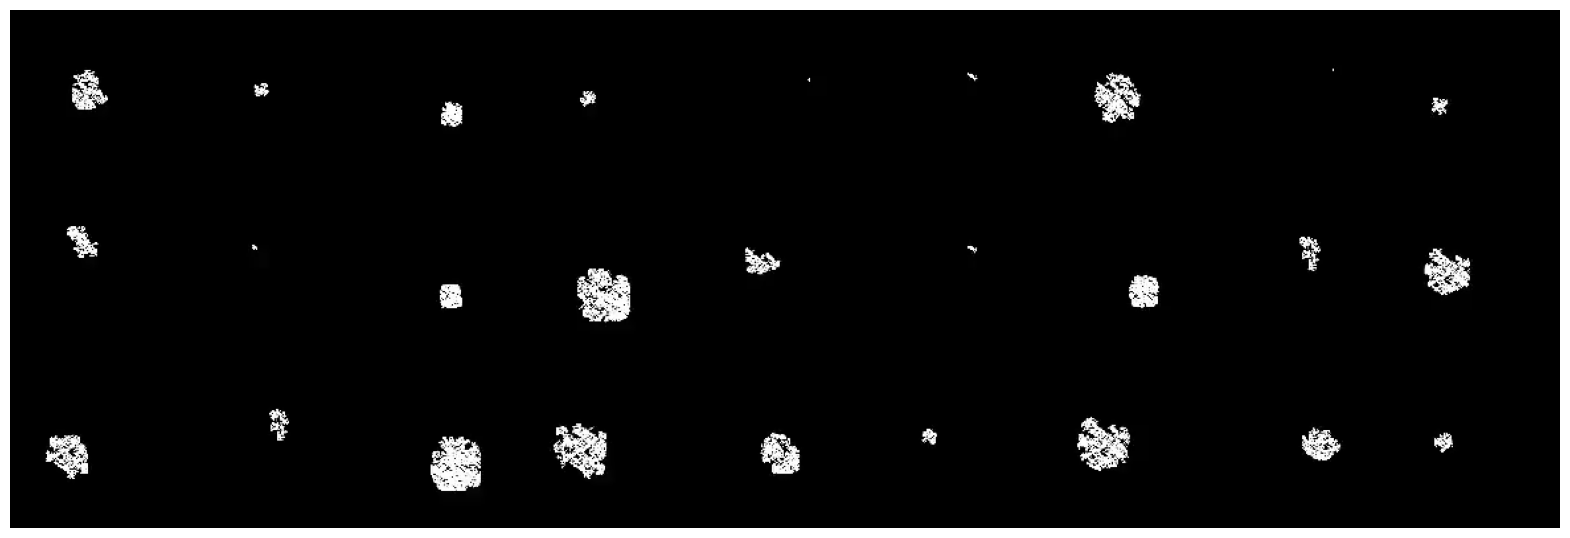

In [8]:
# Visualise a few examples from the train set to be sure it's working
def show(img):
    '''
    function to visualise tensors
    '''
    if torch.cuda.is_available():
        img = img.cpu()
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)).clip(0, 1))

sample_inputs, _ = next(iter(train_loader))
fixed_input = sample_inputs[:27, :, :]

img = make_grid(fixed_input, nrow=9, padding=2, normalize=False,
                value_range=None, scale_each=False, pad_value=0)
plt.figure(figsize=(20,10))
plt.axis('off')
show(img)

### Autoencoder model

In [9]:
# Model parameters
learning_rate = 0.001
num_channels = 1
batch_size = 64
num_epochs = 100

In [50]:
# Define autoencoder model
class Autoencoder(nn.Module):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()

    # encoder
    self.encoder = nn.Sequential(
      nn.Conv2d(num_channels, 8, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.BatchNorm2d(8),
      nn.MaxPool2d(kernel_size=2, stride=2),

      nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.BatchNorm2d(16),
      nn.MaxPool2d(kernel_size=2, stride=2),

      nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.BatchNorm2d(32),
      nn.MaxPool2d(kernel_size=2, stride=2),

      nn.Conv2d(32, latent_dim, kernel_size=3, stride=1, padding=1),
      nn.ReLU(0.2),
      nn.BatchNorm2d(latent_dim),
      nn.MaxPool2d(kernel_size=2, stride=2)
    )

    # decoder
    self.decoder = nn.Sequential(
      nn.ConvTranspose2d(latent_dim, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
      nn.ReLU(0.2),
      nn.BatchNorm2d(32),

      nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
      nn.ReLU(0.2),
      nn.BatchNorm2d(16),
      
      nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=1, output_padding=1),
      nn.ReLU(0.2),
      nn.BatchNorm2d(8),
      
      nn.ConvTranspose2d(8, num_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
      nn.Sigmoid()
    )

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x

In [51]:
# Instantiate autoencoder model
model = Autoencoder(latent_dim=64)
model = model.to(device)

In [52]:
# define optimiser and loss
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [53]:
# Train the autoencoder
for epoch in range(num_epochs):
    for data in train_loader:
        img, _ = data
        img = img.to(device)
        optimizer.zero_grad()
        output = model(img)
        loss = criterion(output, img)
        loss.backward()
        optimizer.step()
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

Epoch [1/100], Loss: 0.1979


Epoch [2/100], Loss: 0.1864
Epoch [3/100], Loss: 0.1784
Epoch [4/100], Loss: 0.1691
Epoch [5/100], Loss: 0.1597
Epoch [6/100], Loss: 0.1505
Epoch [7/100], Loss: 0.1391
Epoch [8/100], Loss: 0.1302
Epoch [9/100], Loss: 0.1147
Epoch [10/100], Loss: 0.1083
Epoch [11/100], Loss: 0.0927
Epoch [12/100], Loss: 0.0850
Epoch [13/100], Loss: 0.0754
Epoch [14/100], Loss: 0.0683
Epoch [15/100], Loss: 0.0621
Epoch [16/100], Loss: 0.0542
Epoch [17/100], Loss: 0.0519
Epoch [18/100], Loss: 0.0475
Epoch [19/100], Loss: 0.0435
Epoch [20/100], Loss: 0.0392
Epoch [21/100], Loss: 0.0364
Epoch [22/100], Loss: 0.0326
Epoch [23/100], Loss: 0.0307
Epoch [24/100], Loss: 0.0296
Epoch [25/100], Loss: 0.0279
Epoch [26/100], Loss: 0.0253
Epoch [27/100], Loss: 0.0231
Epoch [28/100], Loss: 0.0218
Epoch [29/100], Loss: 0.0211
Epoch [30/100], Loss: 0.0201
Epoch [31/100], Loss: 0.0189
Epoch [32/100], Loss: 0.0187
Epoch [33/100], Loss: 0.0170
Epoch [34/100], Loss: 0.0159
Epoch [35/100], Loss: 0.0155
Epoch [36/100], Loss: 

### Visualise model performance on test set

In [54]:
# load test data
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

# Define paths to test directory
test_data_path = './FRAMES/test/'

# Create test dataset
test_dataset = datasets.ImageFolder(test_data_path, transform=transform)

# Create data loaders for test dataset
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

<Figure size 1600x1200 with 0 Axes>

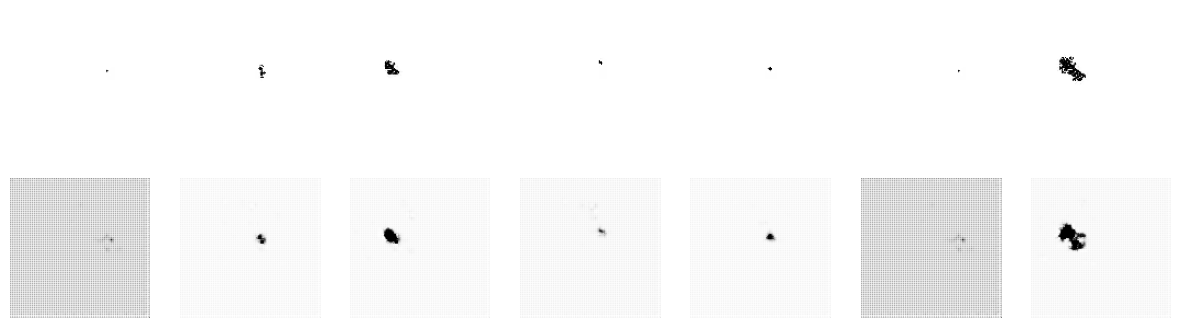

In [55]:
# plot comparison of original image to decoded images
with torch.no_grad():
    for data, _ in test_loader:
        data = data.to(device)
        recon = model(data)
        break
         
import matplotlib.pyplot as plt
plt.figure(dpi=250)
fig, ax = plt.subplots(2, 7, figsize=(15, 4))
for i in range(7):
    ax[0, i].imshow(data[i].cpu().numpy().transpose((1, 2, 0)), cmap='binary')
    ax[1, i].imshow((recon[i].cpu().numpy()).transpose((1, 2, 0)), cmap='binary')
    ax[0, i].axis('OFF')
    ax[1, i].axis('OFF')
plt.show()

### Compare reconstruction accuracy of PCA and CAE against different dimension of the reduced space

Initialise the autoencoder model with different latent dims, compare reconstruction error (MSE, MAE) as with PCA with the equivalent number of principal components.

Although it's specified in 1.1 that PCA should be applied to the training set, it's not specified which data to use in 1.2 - therefore, I will be evaluating these metrics on the test set for both CAE and PCA.

I will calculate the absolute reconstruction error for each frame in the test set. Then, I will find the total MSE and MAE by summing their squares / absolute values respectively and dividing by the number of images in the test set.

In [ ]:
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
# number of latent dims to compare against
dims = [1, 2, 4, 8, 16]

In [ ]:
# PCA
pca_mses, pca_maes = [], []

for dim in dims:
  mse_errors, mae_errors = [], []
  for test_image_batch, _ in test_loader:
    for test_image in test_image_batch:
      test_image = test_image.squeeze().cpu().numpy()
      
      # define PCA model
      pca = PCA(n_components=dim)
      pca.fit(test_image)

      # compress and reconstruct
      transformed = pca.transform(test_image)
      reconstructed = pca.inverse_transform(transformed)

      mse = mean_squared_error(reconstructed.flatten(), test_image.flatten())
      mae = mean_absolute_error(reconstructed.flatten(), test_image.flatten())

      mse_errors.append(mse)
      mae_errors.append(mae)

  # 1. Mean Squared Error: the average of the squared errors across all frames
  total_mse_error = np.mean(mse_errors)
  pca_mses.append(total_mse_error)

  # 2. Mean Average Error: the average of the absolute errors across all frames
  total_mae_error = np.mean(mae_errors)
  pca_maes.append(total_mae_error)

In [ ]:
# CAE
cae_mses, cae_maes = [], []

# Define the loss functions
mse_loss = nn.MSELoss()
mae_loss = nn.L1Loss()

# Set model to evaluation mode
model.eval()

for dim in dims:
  # train a model with dim as latent_dims
  cae = Autoencoder(latent_dim=dim)

  criterion = nn.MSELoss()
  optimizer = optim.Adam(cae.parameters(), lr=learning_rate)

  for epoch in range(num_epochs):
    for data in train_loader:
        img, _ = data
        img = img.to(device)
        optimizer.zero_grad()
        output = cae(img)
        loss = criterion(output, img)
        loss.backward()
        optimizer.step()
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))
  
  mse_errors, mae_errors = [], []
  with torch.no_grad():
    for inputs, _ in test_loader:
      # get the CAE outpus
      inputs = inputs.to(device)
      outputs = cae(inputs)
      
      # Compute reconstruction errors for the current sample
      mse = mse_loss(outputs, inputs)
      mae = mae_loss(outputs, inputs)
      
      # Append the errors to the lists
      mse_errors.append(mse.item())
      mae_errors.append(mae.item())

  # Compute total reconstruction errors (mean over all samples)
  total_mse_error = np.mean(mse_errors)
  total_mae_error = np.mean(mae_errors)

  cae_mses.append(total_mse_error)
  cae_maes.append(total_mae_error)

In [ ]:
plt.plot(dims, pca_mses, label='PCA')
plt.plot(dims, cae_mses, label='CAE')
plt.title("MSE")
plt.legend()
plt.show()

In [ ]:
plt.plot(dims, pca_maes, label='PCA')
plt.plot(dims, cae_maes, label='CAE')
plt.title("MAE")
plt.legend()
plt.show()